In [1]:
# importing

import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt
%matplotlib inline

# not part of Anaconda!!!

import mpld3
import ipy_table

# end not part of Anaconda!

from IPython.display import display, Math, Latex, HTML, clear_output
from scipy import optimize

# set plot text soze
import matplotlib
matplotlib.rcParams.update({'font.size': 14})

import itertools

In [2]:
import seaborn as sns

In [49]:
import pickle
import random

# 1.Preparation 

## 1.1 Parameters for model 

In [3]:
N_eig = 15

In [4]:
#np.save('new_eigenvalues', eigenvalues)
eigenvalues = np.load('eigenvalues/new_eigenvalues.npy')
print(list(eigenvalues))

[(-4.0634477007783438+5.449253669660056j), (-2.3812598117215655+4.5727767454056627j), (-2.0818544666390366+3.338904772165459j), (-4.1600706157232645+0.59493492717025109j), (-0.44738644977382724+4.3253659298876048j), (-1.7087487863145079+3.1725557135407749j), (-2.2223747795561066+4.2248865061699155j), (-0.77799086684856189+5.0142852345559108j), (-0.38459864630598639+0.49380209829310284j), (-3.2997638501510886+1.9383956356352221j), (-2.8298397772329404+5.9989950235578391j), (-0.40125993272094096+5.7801192947621853j), (-3.0819422932146487+1.1734437788363288j), (-0.49678682964610532+0.35221140996145817j), (-4.318565307036585+4.1777408620659653j)]


In [5]:
#fc&fs
fc = np.ones(N_eig)
fs = np.ones(N_eig)

[]

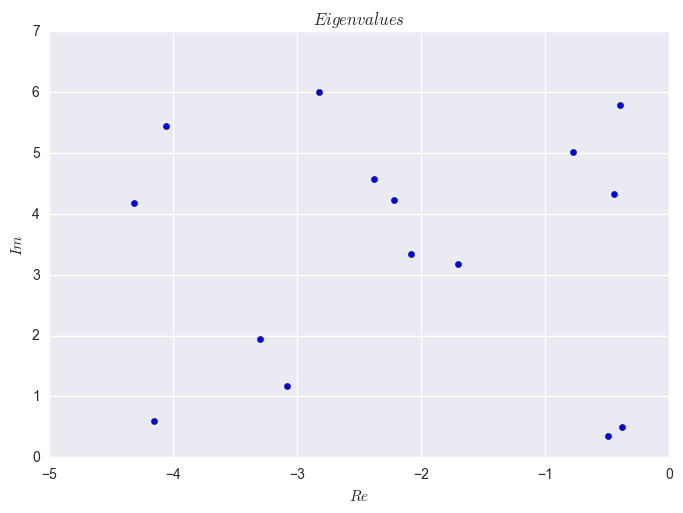

In [6]:
#plot eigenvalues

fig1, axes1 = plt.subplots()

axes1.scatter(eigenvalues.real, eigenvalues.imag)
axes1.set_xlabel('$Re$')
axes1.set_ylabel('$Im$')
axes1.set_title('$Eigenvalues$')
axes1.grid(True)

plt.plot()
#plt.savefig('eigenvalues.png')
#mpld3.display(fig1)
#plt.savefig('fig1.png')

## 1.2 Generate error

In [7]:
def norm_error(eps, n):
    error = []
    for i in range(n):
        a = np.random.normal(scale=eps/3)
        while abs(a)>eps:
            a = np.random.normal(scale=eps/3)
        error.append(a)
    return np.array(error)

In [8]:
def uniform_error(eps, n):
    return np.random.uniform(-eps, eps, size=n)

In [9]:
def two_peaks_error(eps, n):
    error = []
    for i in range(int(n/2)):
        a = np.random.normal(loc=-0.2, scale=eps/3)
        while abs(a)>eps:
            a = np.random.normal(loc=-0.2, scale=eps/3)
        error.append(a)
        a = np.random.normal(loc=0.2, scale=eps/3)
        while abs(a)>eps:
            a = np.random.normal(loc=0.2, scale=eps/3)
        error.append(a)
    if len(error)<n:
        a = np.random.normal(loc=0.2, scale=eps/3)
        while abs(a)>eps:
            a = np.random.normal(loc=0.2, scale=eps/3)
        error.append(a)
    return np.array(error)

## 1.3 Generate Y

$$y_k=\sum_{q=1}^{k-1} h_{k-j}u_j,$$
$$h_k=\sum_{p=1}^P \left(\rho_p^k (f_q^c\cos\omega_p(k-1)+f_q^s\sin\omega_p(k-1)\right)$$,
<center>$\rho_p=\sqrt{\alpha_p^2+\beta_p^2}$,
$\omega_p=arccos\frac{\alpha_p}{\sqrt{\alpha_p^2+\beta_p^2}}$,
$\alpha_p=e^{\lambda_p\Delta}\cos\gamma_p\Delta$,
$\beta_p=e^{\lambda_p\Delta}\sin\gamma_p\Delta$</center>

We set $f_q^c=1$, $f_q^c=1$.

In [10]:
def y_cont(t, eigen, f_c, f_s):
    """continious impulse response"""
    res = 0
    for i in range(N_eig):
        res += (f_c[i]*np.cos(eigen[i].imag*t)+f_s[i]*np.sin(eigen[i].imag*t))*np.exp(eigen[i].real*t)
    return res

[]

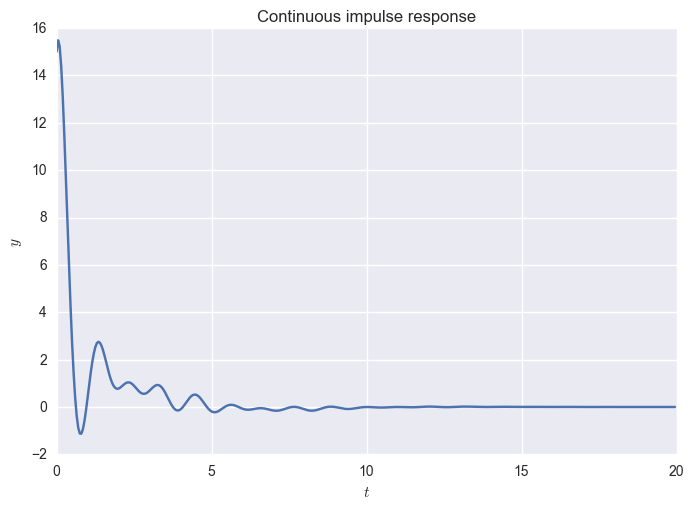

In [11]:
t = np.arange(0, 20, 0.05)
y_c = list(map(lambda x: y_cont(x, eigenvalues, fc, fs), t))

fig2, axes2 = plt.subplots()

axes2.plot(t, y_c)
axes2.set_xlabel('$t$')
axes2.set_ylabel('$y$')
axes2.set_title('Continuous impulse response')

plt.plot()
#mpld3.display(fig2)
#plt.savefig('Response Y.png')

In [12]:
Eps = 0.5 #0.01 - 0.05    *max(y)

In [13]:
T = 19

In [14]:
delta = 0.1

## 1.4 Generate parameters

In [17]:
# phi = np.random.uniform(0, np.pi/2, size=32)
# u_coef = np.random.uniform(-1, 1, size=32)
# w = np.random.uniform(0, 10, size=32)

# with open("coef.gub", 'wb') as f:
#     pickle.dump([phi, u_coef, w], f)

In [18]:
with open("coef.gub", 'rb') as f:
    phi, u_coef, w = pickle.load(f)

In [19]:
print("PHI:\n", phi)
print("Ui:\n",u_coef)
print("Omega:\n", w)

PHI:
 [  9.56778665e-01   2.32272532e-01   2.60491878e-04   1.03816794e-01
   1.24630496e+00   1.07006232e+00   1.36171345e+00   8.86757015e-02
   3.43757458e-01   1.12073679e+00   7.93816100e-01   8.91978688e-01
   1.14714724e+00   4.12255549e-01   2.61541136e-01   7.10780513e-01
   4.50114101e-01   1.25849361e+00   3.29664038e-01   2.09093988e-01
   2.68680949e-01   5.84424812e-01   3.22764460e-01   1.55649877e+00
   2.02070042e-01   2.96959888e-01   3.84216704e-01   1.30804057e+00
   1.10305994e+00   1.21128225e+00   1.30232664e+00   7.35651319e-01]
Ui:
 [  5.82181179e-01  -1.09790640e-04  -7.13645146e-01   9.10412471e-01
   1.93063860e-01   7.99101418e-01  -3.56443787e-01   8.16353502e-01
  -2.35803610e-01  -9.63366320e-01   5.93888296e-01  -1.90154501e-01
   6.80649451e-01  -2.81589785e-01   4.48524259e-01  -6.95006329e-01
   8.99377437e-01   3.25078512e-01  -5.19822833e-01  -2.55921615e-01
   2.08686571e-01   8.58156418e-01  -8.11475906e-01   3.38364394e-01
   8.51457304e-01   3.

<center>$\alpha_p=e^{\lambda_p\Delta}\cos\gamma_p\Delta$</center> 
<center>$\beta_p=e^{\lambda_p\Delta}\sin\gamma_p\Delta$</center>

In [20]:
def gen_alpha_beta(delta):
    alpha = [np.exp(el.real*delta)*np.cos(el.imag*delta) for el in eigenvalues]
    beta = [np.exp(el.real*delta)*np.sin(el.imag*delta) for el in eigenvalues]
    return np.array(alpha), np.array(beta)

In [21]:
N = int(T/delta)

In [60]:
print(N)

190


In [22]:
alpha, beta = gen_alpha_beta(delta)

<center>$\rho_p=\sqrt{\alpha_p^2+\beta_p^2}$, $\omega_p=arccos\frac{\alpha_p}{\sqrt{\alpha_p^2+\beta_p^2}}$ </center>

---
$$y_k=\sum_{q=1}^{k-1} h_{k-j}u_j,$$
---
$$h_k=\sum_{p=1}^P \left(\rho_p^k (f_q^c\cos\omega_p(k-1)+f_q^s\sin\omega_p(k-1))\right)$$
---

In [27]:
def gen_realy_u_h(delta, N, alpha, beta):
    rho = [np.sqrt(alpha[i]**2+beta[i]**2) for i in range(len(alpha))]
    omega = [np.arccos(alpha[i]/rho[i]) for i in range(len(alpha))]
    #print(len(rho), len(omega))
    h = [sum([rho[j]**i*(fc[j]*np.cos(omega[j]*i)+fs[j]*np.sin(omega[j]*i)) for j in range(len(omega))]) for i in range(N)]
    u = [sum([u_coef[i]*np.sin(w[i]*delta*k+phi[i]) for i in range(32)]) for k in range(N)]
    u /= max(map(abs, u))
    y = [sum([h[i-j]*u[j] for j in range(i+1)]) for i in range(N)]
    return np.array(y), np.array(u), np.array(h)

In [28]:
y_real, u, h_real = gen_realy_u_h(delta, N, alpha, beta)

In [86]:
np.random.seed(0)
error1 = two_peaks_error(Eps, N)
print(error1)
y = y_real+error1

[ 0.09400872  0.26669287 -0.036877    0.03712035 -0.04165193  0.1747738
 -0.21720314  0.26843308 -0.17599274  0.44237892 -0.07316038  0.22027917
 -0.12602279  0.25561239  0.04901318  0.16580696 -0.14782205  0.05765071
 -0.09106357  0.3440727  -0.32369417 -0.04239428 -0.19237358  0.16880269
  0.0554632   0.44489313 -0.17417543  0.26302709 -0.34796429 -0.13013274
 -0.25798536  0.22605816  0.00504845  0.40039664 -0.26455447  0.14961621
 -0.37475883 -0.03666966 -0.48437837  0.11505797 -0.27301238 -0.00879923
 -0.07041827 -0.06898297 -0.23545671  0.05075557 -0.13551625  0.11486581
 -0.39677203  0.19530296 -0.12861135  0.2110862  -0.14958802  0.09427965
 -0.26045686  0.08792326 -0.25992553  0.06447562 -0.48771377  0.22957102
 -0.26696349 -0.07169972 -0.12286962  0.04878361 -0.19134243  0.32151509
 -0.17850285  0.38990011 -0.4058043   0.26705694 -0.31413502  0.05486714
 -0.29647494  0.14807458 -0.19063911  0.00580836 -0.04986225  0.27761041
 -0.45604061  0.44804203  0.11598153  0.39646326 -0.

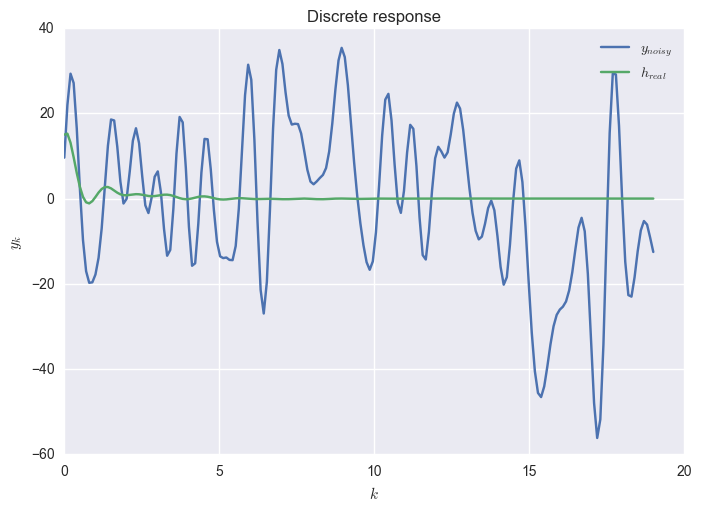

In [88]:
t = np.linspace(0, T, N)

fig3, axes3 = plt.subplots()

axes3.plot(t, y_real, label = '$y_{noisy}$')
axes3.plot(t, h_real, label = '$h_{real}$')
axes3.set_xlabel('$k$')
axes3.set_ylabel('$y_k$')
axes3.legend()
axes3.set_title('Discrete response')

plt.plot()
fig3.savefig("two_peaks_response.png")

In [93]:
def plot_error(error, eps,folder=''):
    """
    generate hist for error
    """
    fig4, axes4 = plt.subplots()

    weights = np.ones_like(error)/(float(len(error)))

    n, bins, patches = axes4.hist(error, 50, range = (-1.0, 1.0), facecolor='blue', weights=weights)

    axes4.set_xlabel('error')
    axes4.set_ylabel('likelihood')
    axes4.set_xlim(-1.3*eps, 1.3*eps)
    axes4.set_ylim(0, max(n)+0.05)
    axes4.set_title('Error plot')
    
    fig4.savefig(folder+'Error_plot.png')
    plt.plot()
    

In [106]:
def generate_values(eps, delta, T, gen_error, if_plot=False, folder = ''):
    """
    return: alpha, beta, y_real, u, h_real, error, y
    """
    np.random.seed(0)
    N = int(T/delta)
    K = N+5
    
    alpha, beta = gen_alpha_beta(delta)
    y_real, u, h_real = gen_realy_u_h(delta, N+K, alpha, beta)

    #np.random.seed()
    error = gen_error(eps, N+K)
    assert(len(error) == len(y_real))
    y = y_real + error
    
    if if_plot:        
        t = [delta*i for i in range(N+K)]
        
        fig2, axes2 = plt.subplots(figsize=(16, 7))
        
        axes2.plot(t, u, label = '$u$')
        axes2.set_xlabel('$k$')
        axes2.set_ylabel('$y_{k}$')
        axes2.legend()
        axes2.set_title('U')
        fig2.savefig(folder+'U.png')
        
        fig3, axes3 = plt.subplots(figsize=(16, 7))

        axes3.plot(t, y_real, label = '$y_{noisy}$')
        axes3.plot(t, h_real, label = '$h_{real}$')
        axes3.set_xlabel('$k$')
        axes3.set_ylabel('$y_k$')
        axes3.legend()
        axes3.set_title('Discrete response')
        fig3.savefig(folder+'Discrete response.png')
        
        fig4, axes4 = plt.subplots(figsize=(16, 7))

        axes4.plot(t, [y_real[i]/error[i] for i in range(N+K)])
        axes4.set_xlabel('k')
        axes4.set_ylabel('$y_k$/$error_k$')
        axes4.set_title('Signal/error (k)')
        fig4.savefig(folder+'Signal-error.png')
        plt.plot()
        #mpld3.display(fig3)
        
        plot_error(error, eps, folder)
    return alpha, beta, y_real, u, h_real, error, y

## 1.6 Calculating confidence intervals

In [63]:
def random_combination(iterable, r):
    # combinations('ABCD', 2) --> AB AC AD BC BD CD
    # combinations(range(4), 3) --> 012 013 023 123
    "Random selection from itertools.combinations(iterable, r)"
    pool = tuple(iterable)
    n = len(pool)
    indices = sorted(random.sample(range(n), r))
    return tuple(pool[i] for i in indices)

In [78]:
def calc_confidence_intervals(u, y, eps):
    #print(len(u))
    N = int((len(u)-5)/2)
    K = N + 5
    #The Toeplitz matrix has constant diagonals, with c as its first column and r as its first row. 
    matr = scipy.linalg.toeplitz(c=u[N:N+K], r=u[N::-1])
    h_low = np.ones(N)*-1000
    h_up = np.ones(N)*1000
    satisfied = 0
    combinations = []
    #for i in range(min(2000, int(scipy.special.binom(K, K-N-1)))):
    print("binom: ", scipy.special.binom(K, K-N-1))
    for i in range(int(scipy.special.binom(K, K-N-1))):
        comb = random_combination(range(K), K-N-1)
        while comb in combinations:
            comb = random_combination(range(K), K-N-1)
        combinations.append(comb)
        U = np.delete(matr, comb, 0)
        y_vec = np.delete(y[N:], comb)
        if np.linalg.cond(U, p=2) < 100: # condition number
            satisfied += 1
            U_inv = scipy.linalg.inv(U)
            h_cent_temp = np.dot(U_inv, y_vec)
            h_delta = [eps*sum(abs(U_inv[i])) for i in range(len(h_cent_temp))]
            h_up_temp = h_cent_temp + h_delta
            h_low_temp = h_cent_temp - h_delta
            h_low = [max(h_low[i], h_low_temp[i]) for i in range(N)]
            h_up = [min(h_up[i], h_up_temp[i]) for i in range(N)]
        h_cent = [(h_low[i]+h_up[i])/2 for i in range(N)]
    print("equations:", satisfied)
    return h_cent, h_low, h_up

In [65]:
def calc_percent(h_real, h_low, h_up):
    return sum([int(h_low[i]<=h_real[i] and h_up[i]>=h_real[i]) for i in range(len(h_low))])/float(len(h_low))

In [99]:
def plot_res(T, delta, h_real, h_low, h_up,folder=''):
    '''
    plot true interval for h
    '''
    t = np.linspace(0, T, int(T/delta))

    fig, ax = plt.subplots(figsize=(16, 7))
    ax.plot(t, h_real[:len(t)], label='$h_{real}$')
    #ax.plot(t, list(map(lambda x: y_cont(x, eigenvalues, fc, fs), t)), label='$h_{cont}$')
    ax.plot(t, h_up, label = '$h_{upper}$')
    ax.plot(t, h_low, label = '$h_{low}$')
    ax.legend()
    ax.set_xlabel('k')
    ax.set_title('$h_k$')
    fig.savefig(folder+'intervals.png')

    print("% =", calc_percent(h_real, h_low, h_up))

In [67]:
def calculate_perc_for_seq(eps, delta, T, gen_error, delta_delta = -0.01):
    perc = {}
    for i in range(10):
        delta +=delta_delta
        if delta < 0.000000001:
            break
        alpha, beta, y_real, u, h_real, error, y = generate_values(eps, delta, T, gen_error)
        h_cent, h_low, h_up = calc_confidence_intervals(u, y, eps)
        print("max interval width:", max([h_up[i] - h_low[i] for i in range(int(T/delta))]))
        perc["{0:.3f}".format(delta)] = calc_percent(h_real, h_low, h_up)
    return perc

In [79]:
calculate_perc_for_seq(0.4, 1, T, norm_error)

binom:  10626.0
equations: 6767
max interval width: 3.75555083356
binom:  10626.0
equations: 4582
max interval width: 6.30573694864
binom:  10626.0
equations: 1624
max interval width: 12.1310063246
binom:  10626.0
equations: 7034
max interval width: 5.31634718748
binom:  12650.0
equations: 7095
max interval width: 5.84949581427
binom:  12650.0
equations: 4680
max interval width: 6.75709561189
binom:  12650.0
equations: 8799
max interval width: 4.73621216583
binom:  12650.0
equations: 8796
max interval width: 2.92157494041
binom:  12650.0
equations: 9752
max interval width: 2.92618338856
binom:  14950.0
equations: 9299
max interval width: 3.55587419981


{'0.900': 1.0,
 '0.910': 1.0,
 '0.920': 1.0,
 '0.930': 1.0,
 '0.940': 1.0,
 '0.950': 1.0,
 '0.960': 1.0,
 '0.970': 1.0,
 '0.980': 1.0,
 '0.990': 1.0}

In [101]:
def make_results(eps, delta, T, gen_error, folder=''):
    alpha, beta, y_real, u, h_real, error, y = generate_values(eps, delta, T, gen_error, if_plot=True, folder = folder)
    h_cent, h_low, h_up = calc_confidence_intervals(u, y, eps)
    #h_low, h_up = calc_confidence_intervals(h_cent, eps, u0, u1)
    plot_res(T, delta, h_real, h_low, h_up, folder)
    return y, u, h_cent, h_low, h_up



binom:  10626.0
equations: 7077
% = 1.0


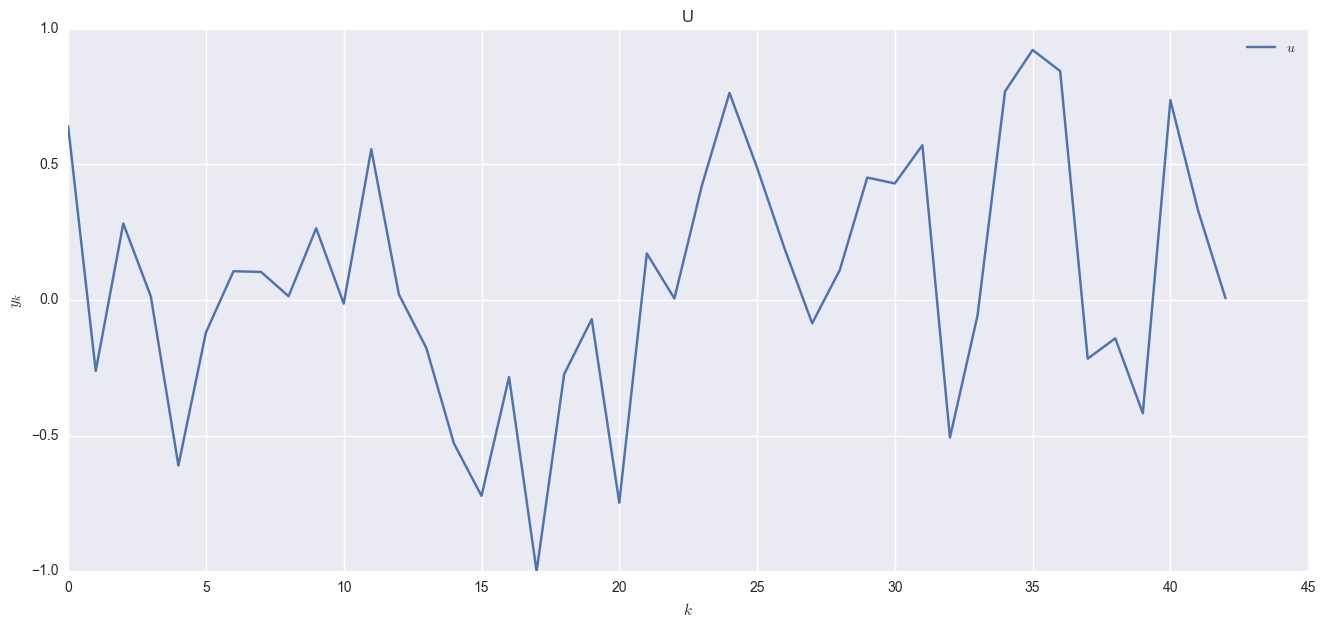

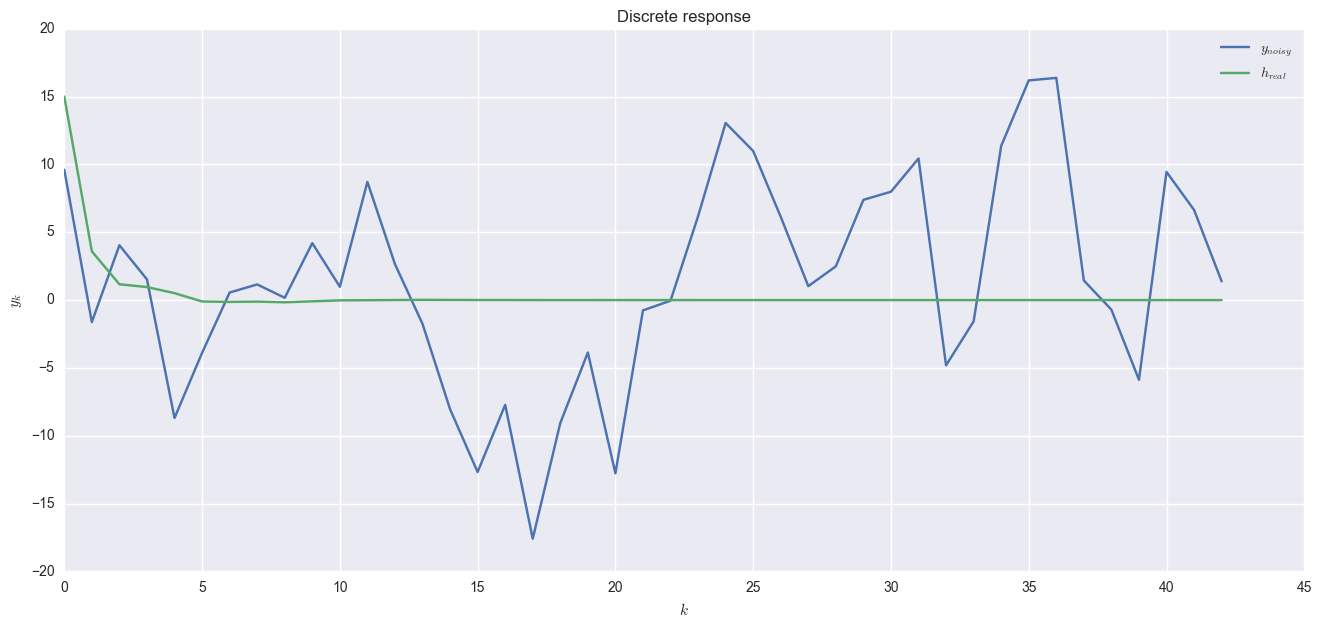

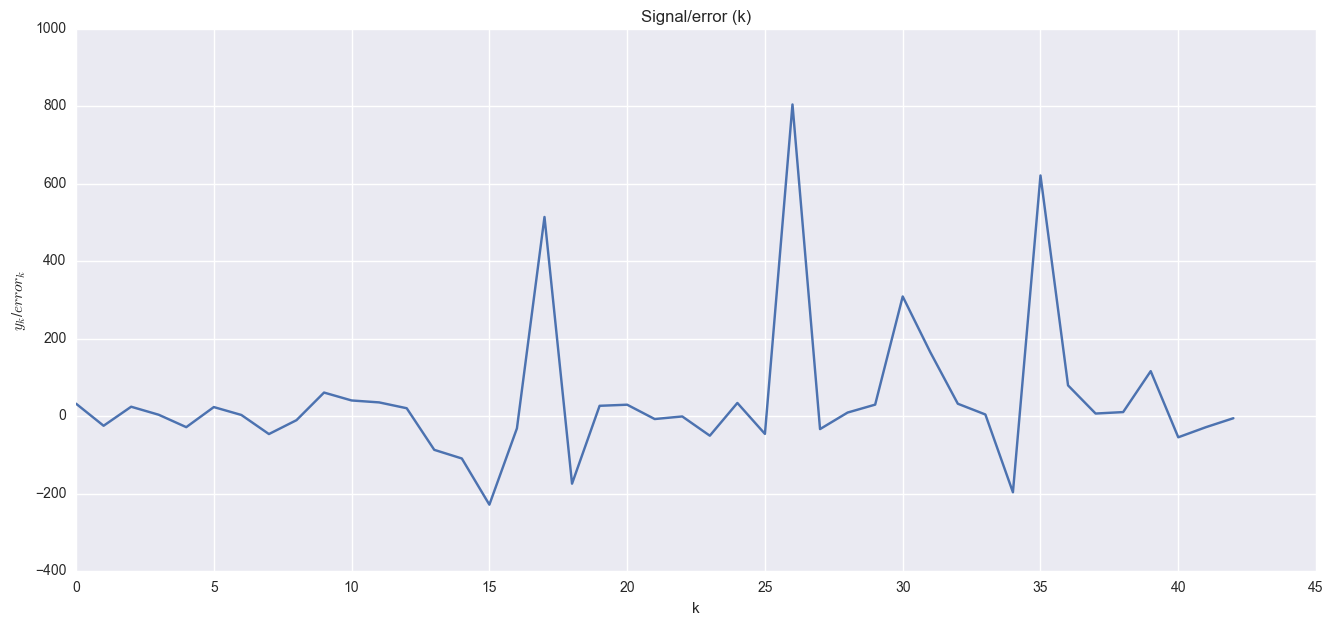

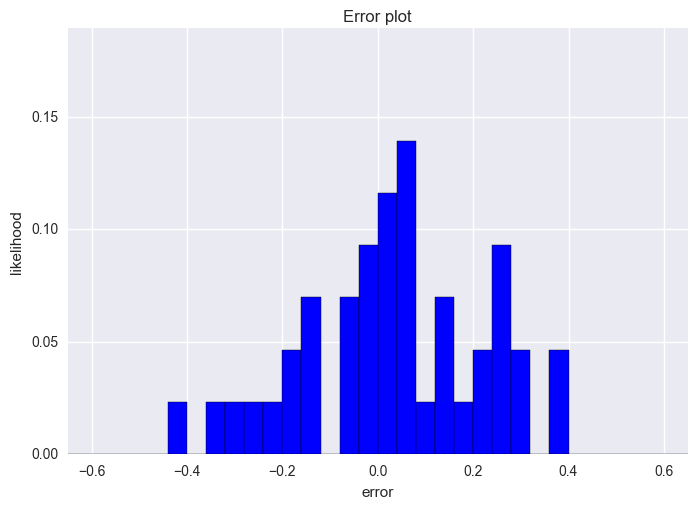

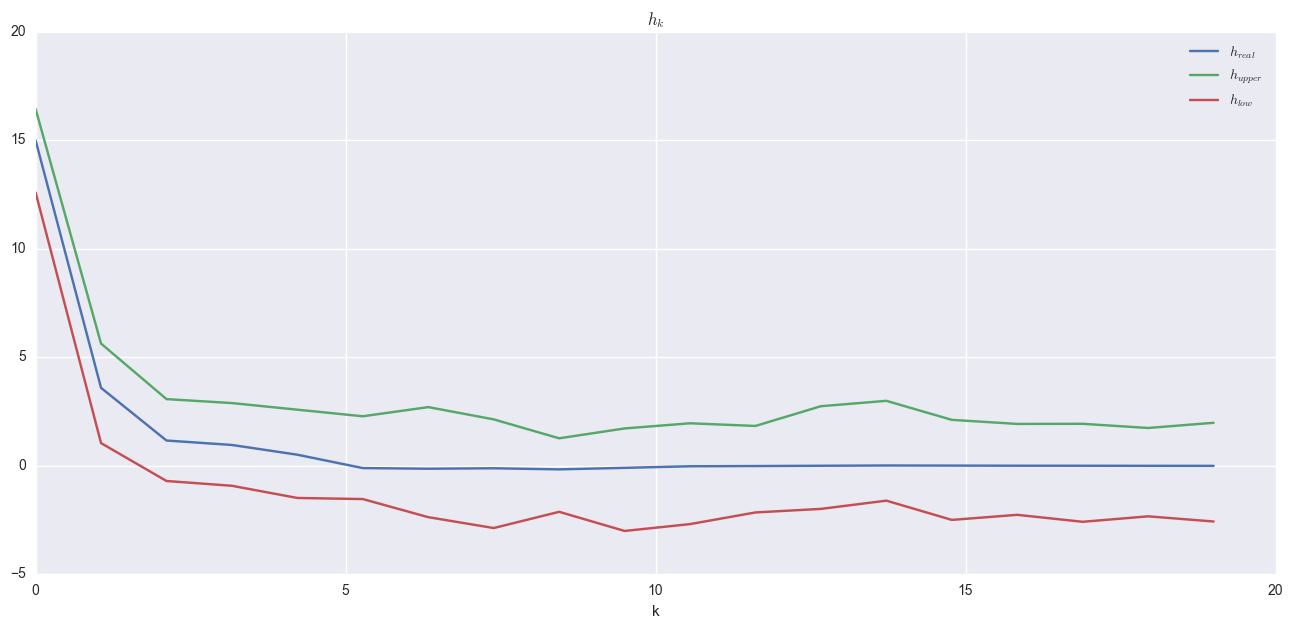

In [107]:
y, u, h_cent, h_low, h_up = make_results(0.5, 1, 19, norm_error, '2method/norm/')

binom:  10626.0
equations: 7077
% = 1.0


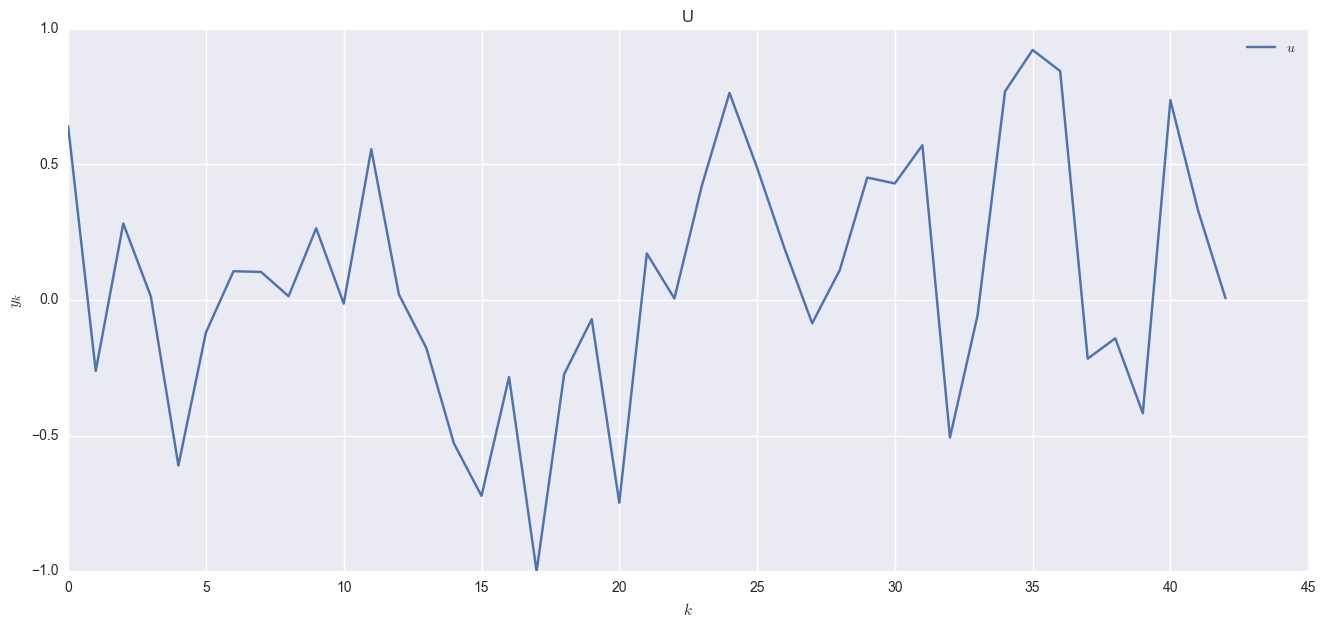

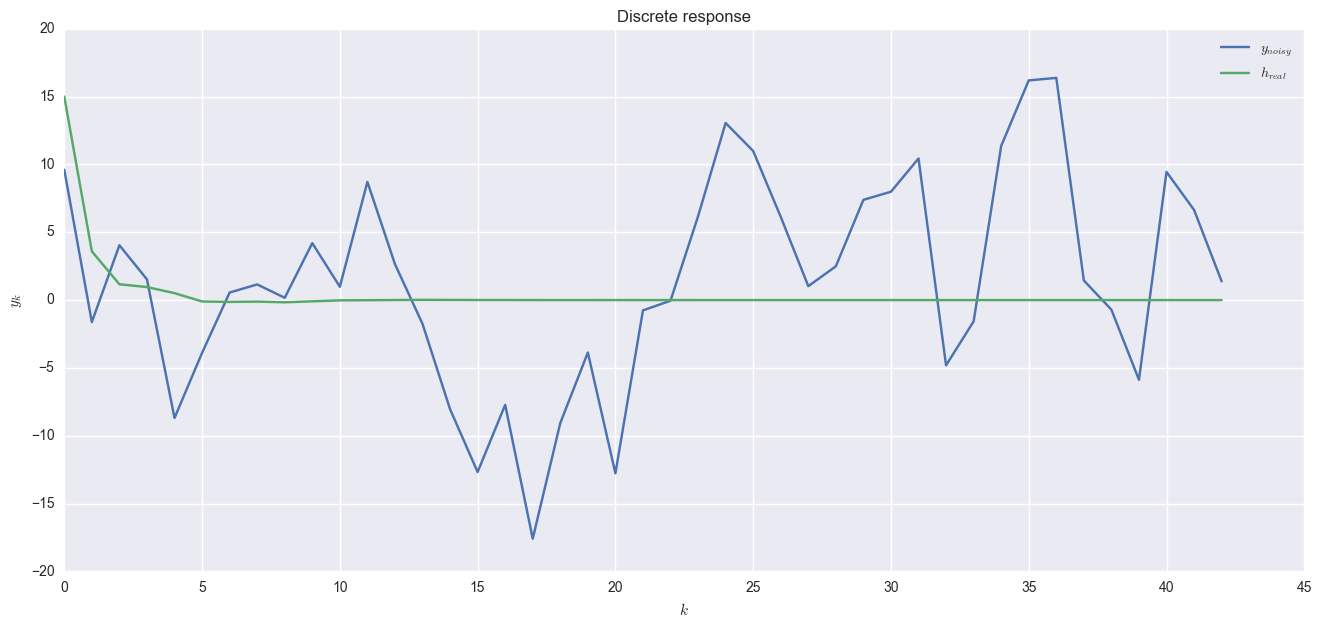

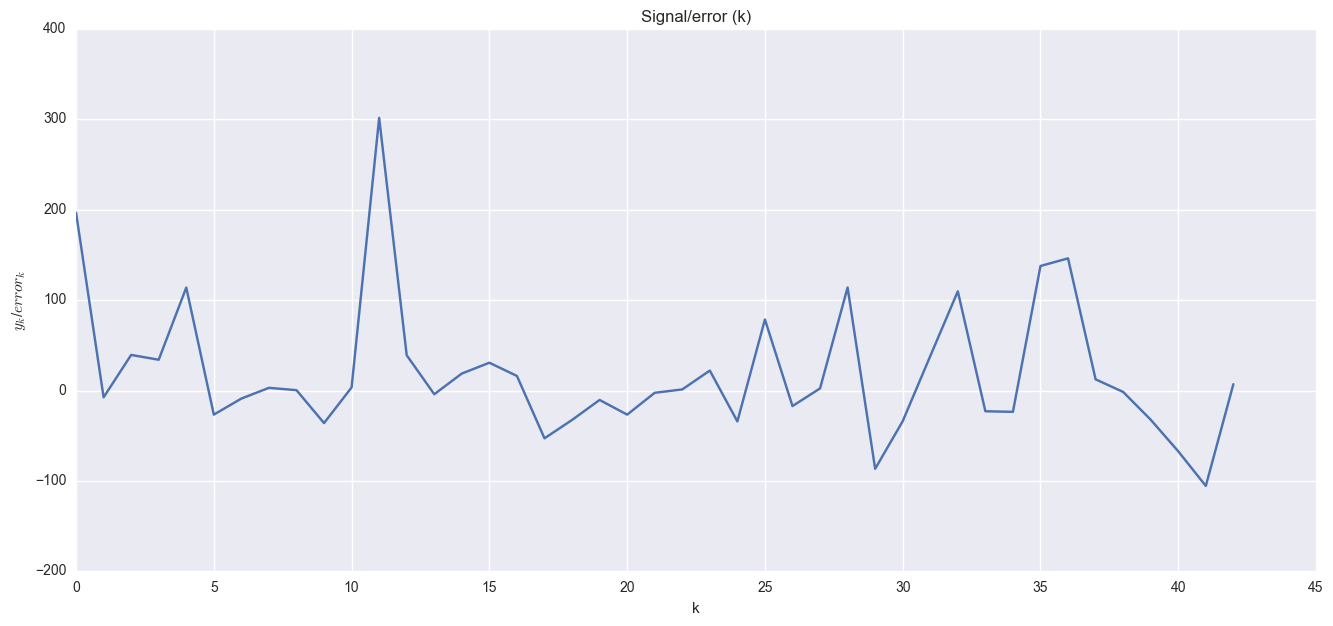

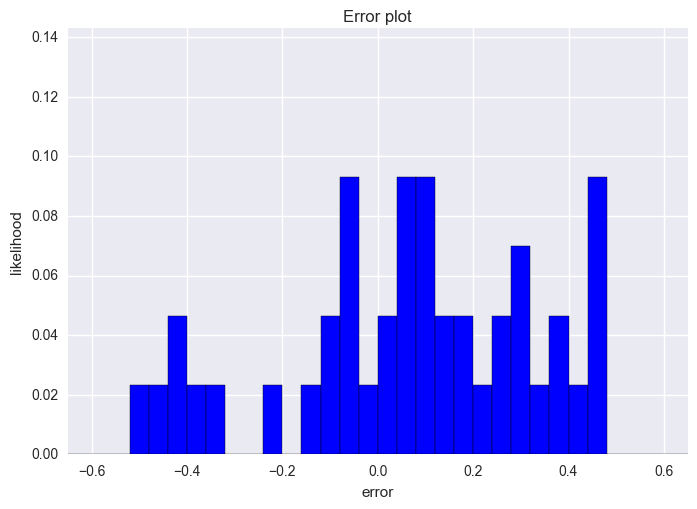

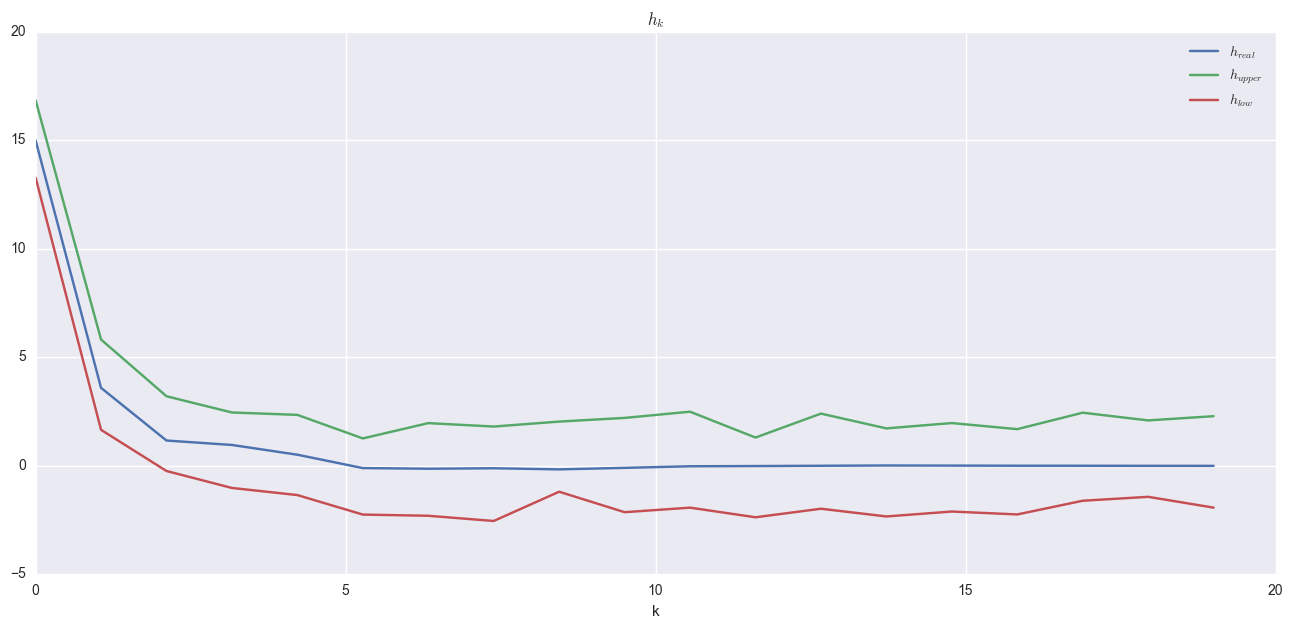

In [109]:
y, u, h_cent, h_low, h_up = make_results(0.5, 1, 19, uniform_error, '2method/2uniform/')

binom:  10626.0
equations: 7077
% = 1.0


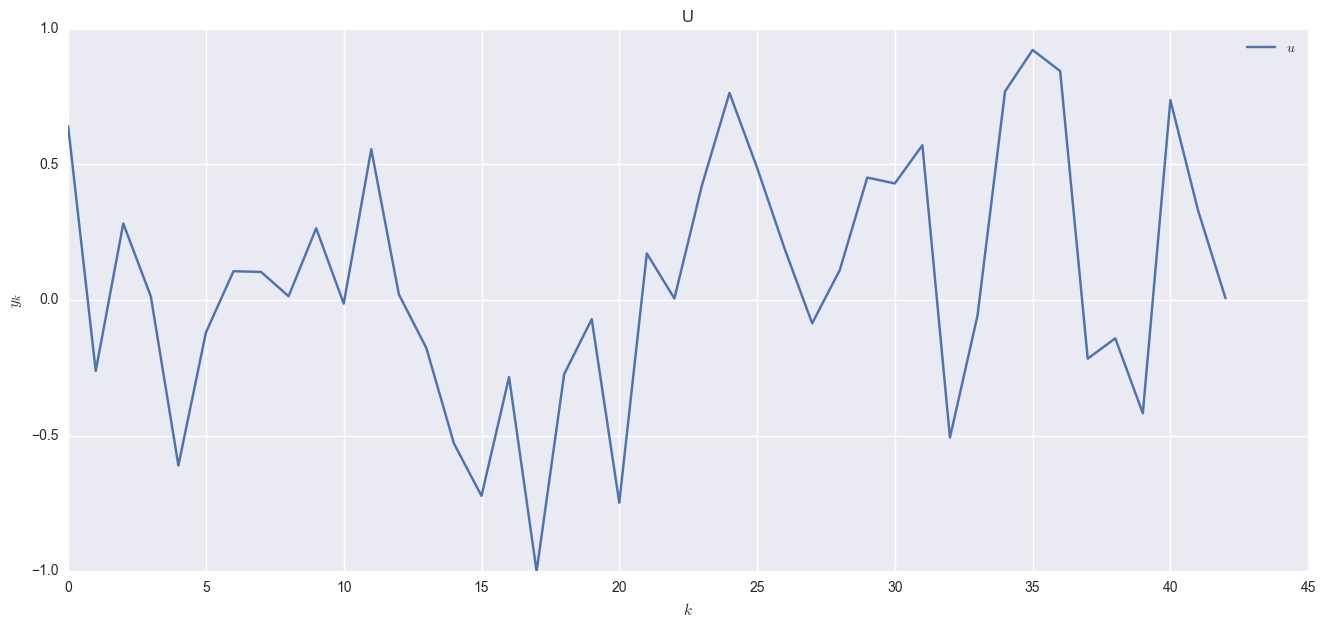

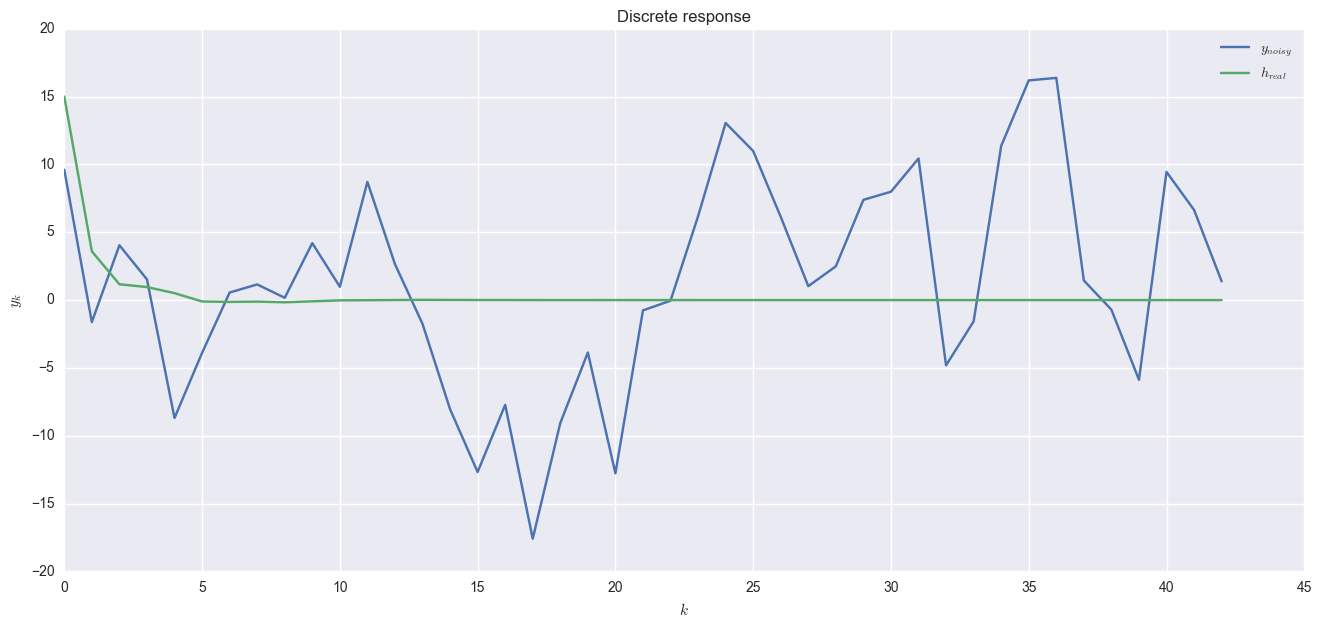

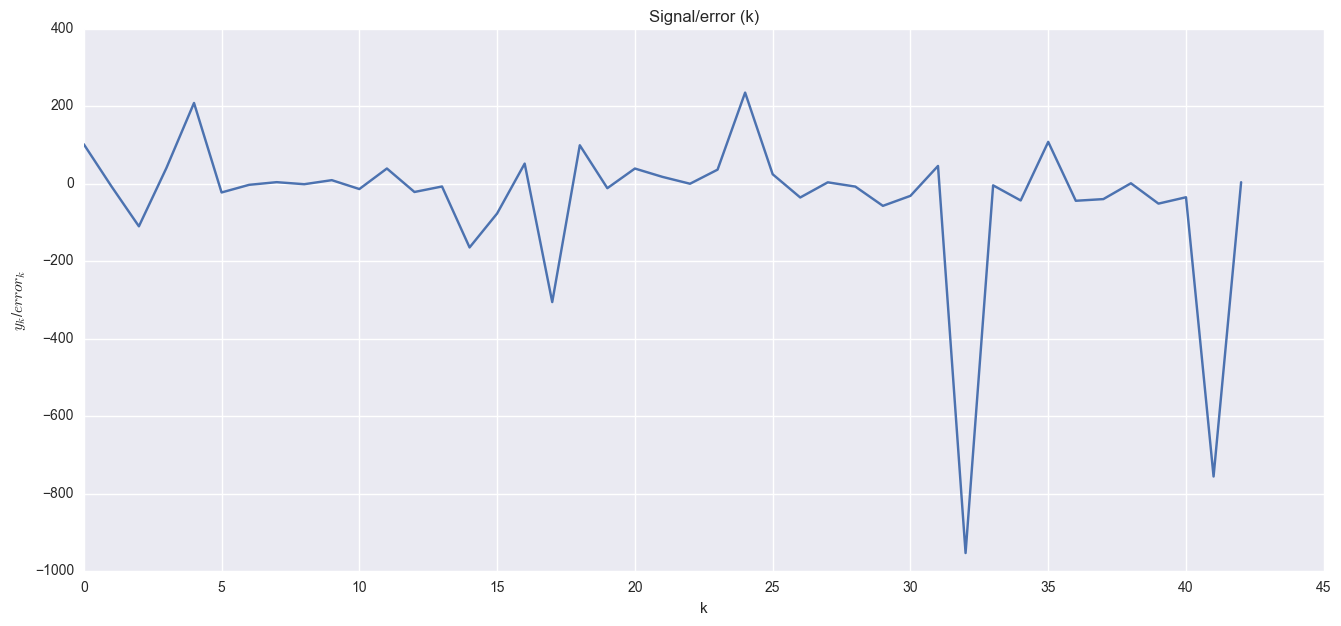

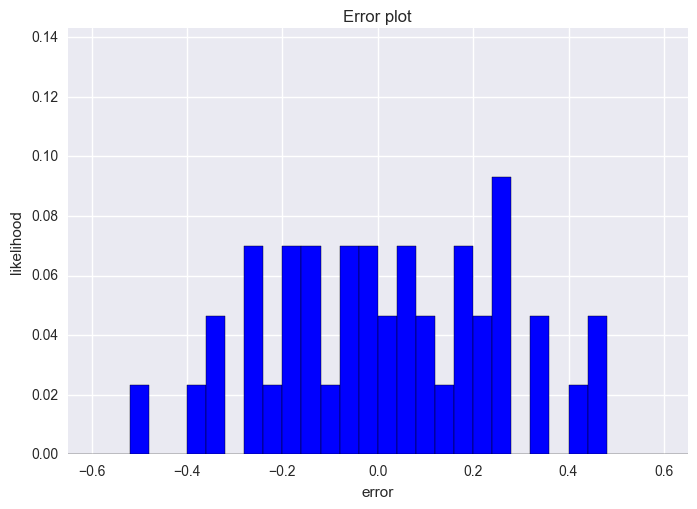

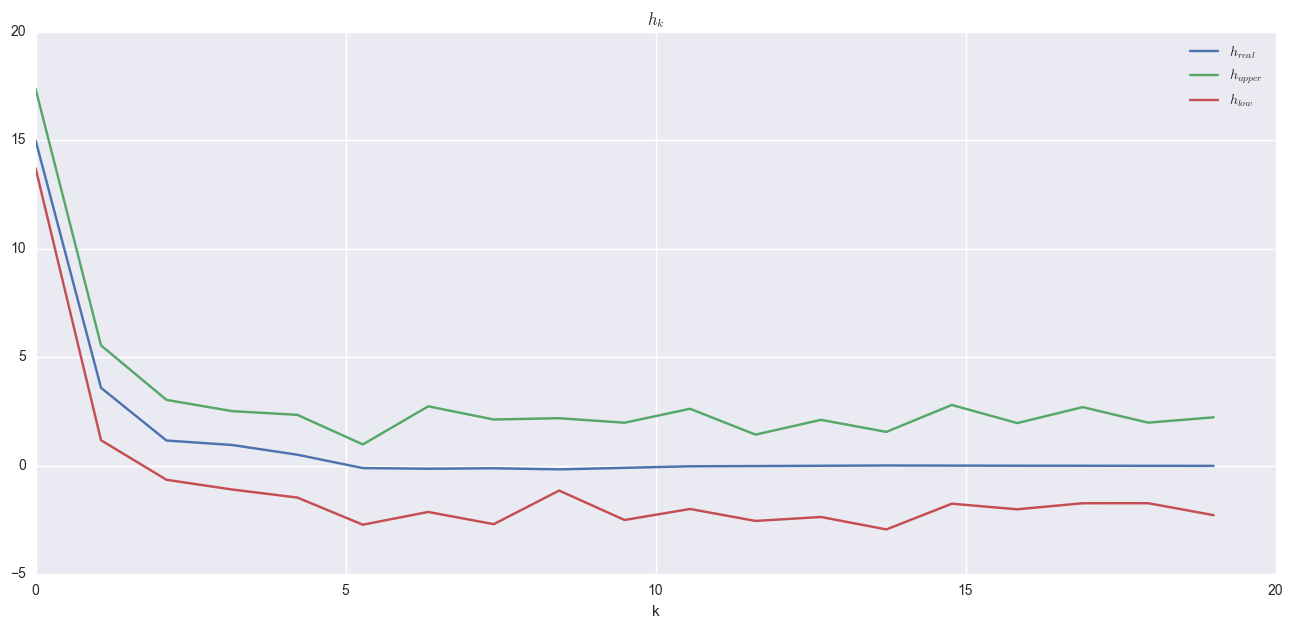

In [108]:
y, u, h_cent, h_low, h_up = make_results(0.5, 1, 19, two_peaks_error, '2method/two_peaks')